# Demo

### Download Model Params

In [8]:
import os
CHECKPOINT_PATH="Cnn14_DecisionLevelMax_mAP=0.385.pth"
if not os.path.exists(CHECKPOINT_PATH):
    os.system(f"wget -N {CHECKPOINT_PATH} https://zenodo.org/record/3987831/files/Cnn14_DecisionLevelMax_mAP%3D0.385.pth\?download\=1")

### SED Inference

In [9]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy as np
import argparse
import librosa
import matplotlib.pyplot as plt
import torch

from utils.utilities import create_folder, get_filename
from model.models import *
from model.pytorch_utils import move_data_to_device
from utils import config

def my_sound_event_detection(audiofile):
    """Inference sound event detection result of an audio clip.
    """
    # Arugments & parameters
    sample_rate = 32000
    window_size = 1024
    hop_size = 320
    mel_bins = 64
    fmin = 50
    fmax = 14000
    model_type = "Cnn14_DecisionLevelMax"
    checkpoint_path = "Cnn14_DecisionLevelMax_mAP=0.385.pth"
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # for i in range(26):
    audio_path = os.path.join("..", "data", audiofile)
    classes_num = config.classes_num
    labels = config.labels
    frames_per_second = sample_rate // hop_size

    # Paths
    fig_path = os.path.join('results', '{}.png'.format(get_filename(audio_path)))
    create_folder(os.path.dirname(fig_path))

    # Model
    Model = eval(model_type)
    model = Model(sample_rate=sample_rate, window_size=window_size, 
        hop_size=hop_size, mel_bins=mel_bins, fmin=fmin, fmax=fmax, 
        classes_num=classes_num)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    model = torch.nn.DataParallel(model)

    if 'cuda' in str(device):
        model.to(device)
    
    # Load audio
    (waveform, _) = librosa.core.load(audio_path, sr=sample_rate, mono=True)
    waveform = waveform[None, :]    # (1, audio_length)
    waveform = move_data_to_device(waveform, device)

    # Forward
    with torch.no_grad():
        model.eval()
        batch_output_dict = model(waveform, None)

    framewise_output = batch_output_dict['framewise_output'].data.cpu().numpy()[0]
    """(time_steps, classes_num)"""

    print('Sound event detection result (time_steps x classes_num): {}'.format(
        framewise_output.shape))

    sorted_indexes = np.argsort(np.max(framewise_output, axis=0))[::-1]

    top_k = 5  # Show top results
    top_result_mat = framewise_output[:, sorted_indexes[0 : top_k]]    
    """(time_steps, top_k)"""

    # Plot result    
    stft = librosa.core.stft(y=waveform[0].data.cpu().numpy(), n_fft=window_size, 
        hop_length=hop_size, window='hann', center=True)
    frames_num = stft.shape[-1]

    fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 4))
    axs.matshow(top_result_mat.T, origin='upper', aspect='auto', cmap='jet', vmin=0, vmax=1)
    axs.xaxis.set_ticks(np.arange(0, frames_num, frames_per_second))
    axs.xaxis.set_ticklabels(np.arange(0, frames_num / frames_per_second))
    axs.yaxis.set_ticks(np.arange(0, top_k))
    axs.yaxis.set_ticklabels(np.array(labels)[sorted_indexes[0 : top_k]])
    axs.yaxis.grid(color='k', linestyle='solid', linewidth=0.3, alpha=0.3)
    axs.set_xlabel('Seconds')
    axs.xaxis.set_ticks_position('bottom')

    plt.tight_layout()
    plt.savefig(fig_path)
    print('Save sound event detection visualization to {}'.format(fig_path))

    return framewise_output, np.array(labels)[sorted_indexes[0 : top_k]].tolist()

Sound event detection result (time_steps x classes_num): (1257, 527)
Save sound event detection visualization to results/sound3.png
Sound event detection result (time_steps x classes_num): (1243, 527)
Save sound event detection visualization to results/sound4.png
Sound event detection result (time_steps x classes_num): (941, 527)
Save sound event detection visualization to results/sound5.png
Sound event detection result (time_steps x classes_num): (1147, 527)
Save sound event detection visualization to results/sound6.png
Sound event detection result (time_steps x classes_num): (1143, 527)
Save sound event detection visualization to results/sound7.png
Sound event detection result (time_steps x classes_num): (999, 527)
Save sound event detection visualization to results/sound8.png
Sound event detection result (time_steps x classes_num): (1173, 527)
Save sound event detection visualization to results/sound9.png
Sound event detection result (time_steps x classes_num): (1152, 527)
Save soun

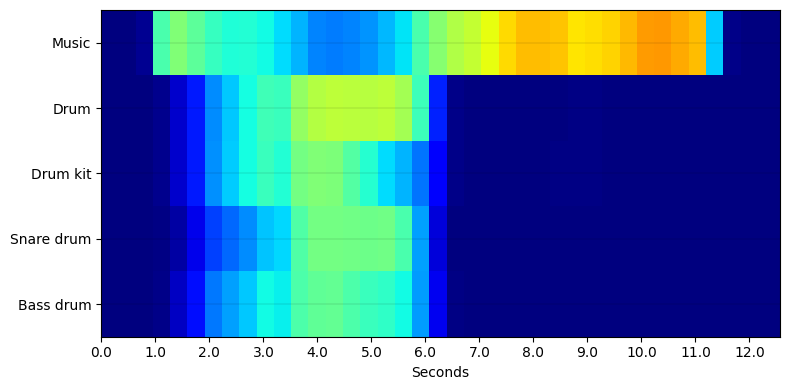

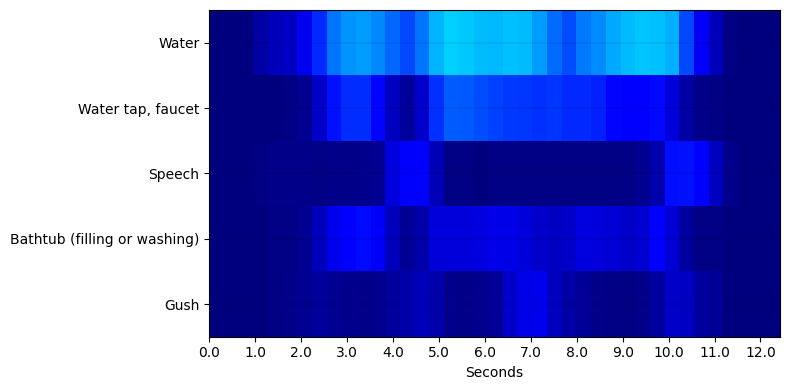

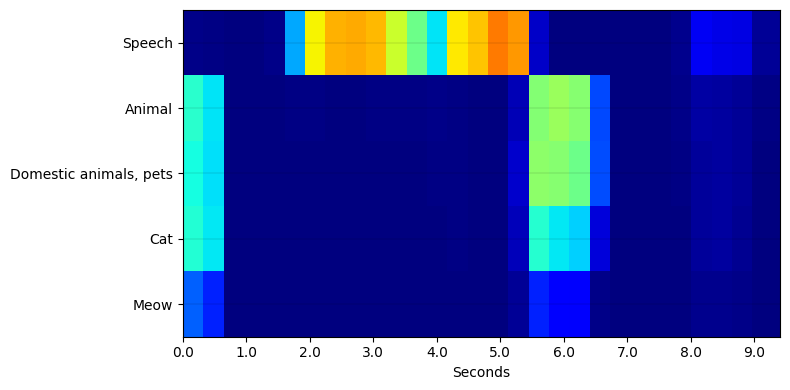

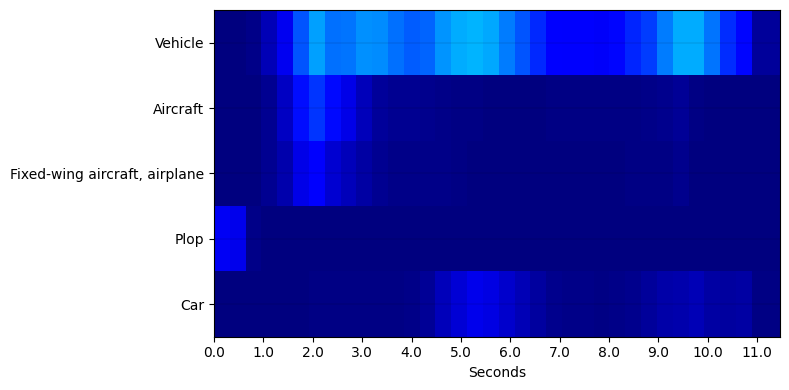

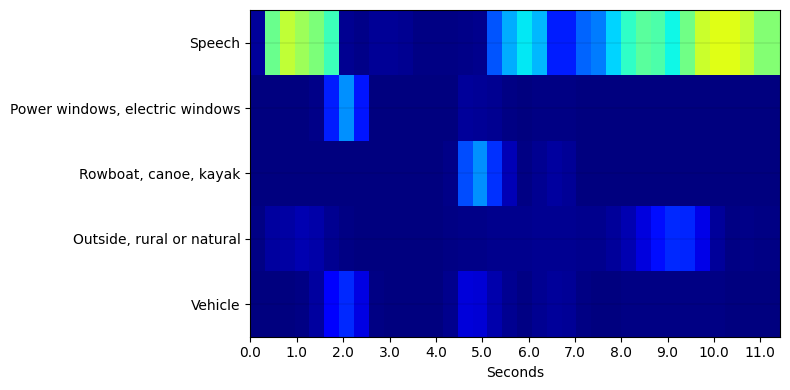

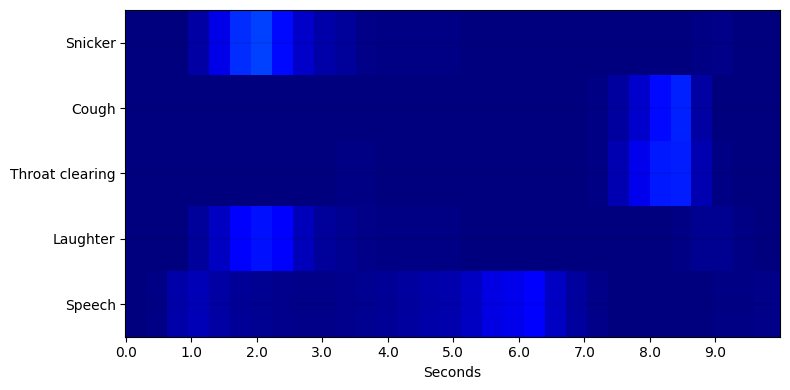

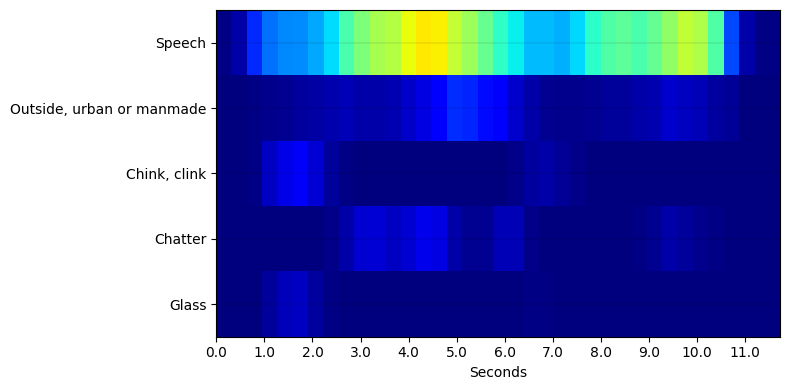

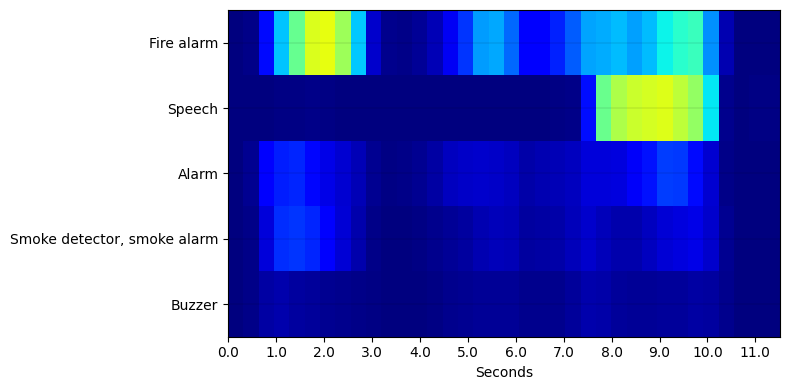

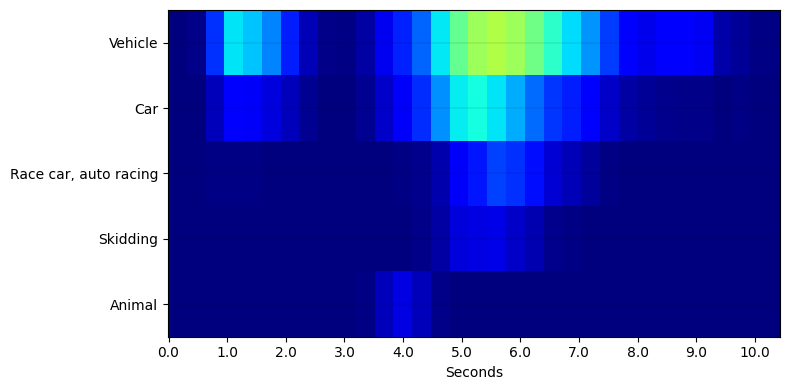

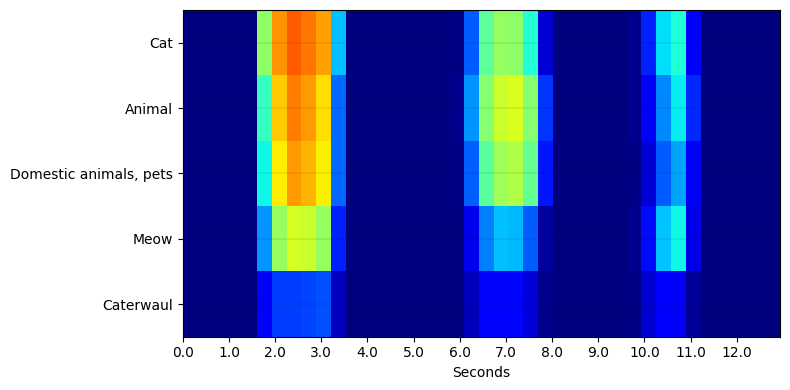

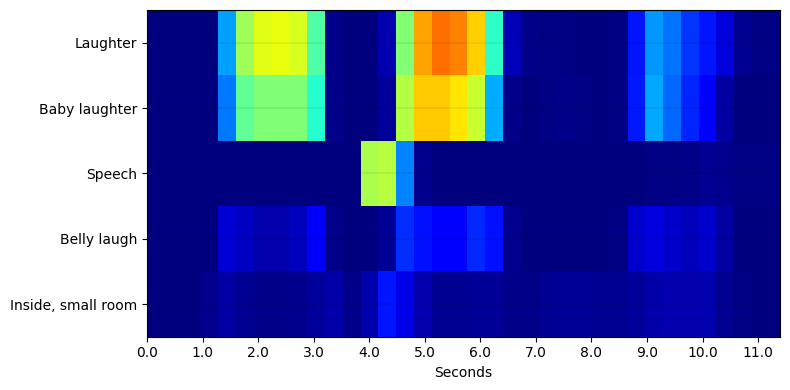

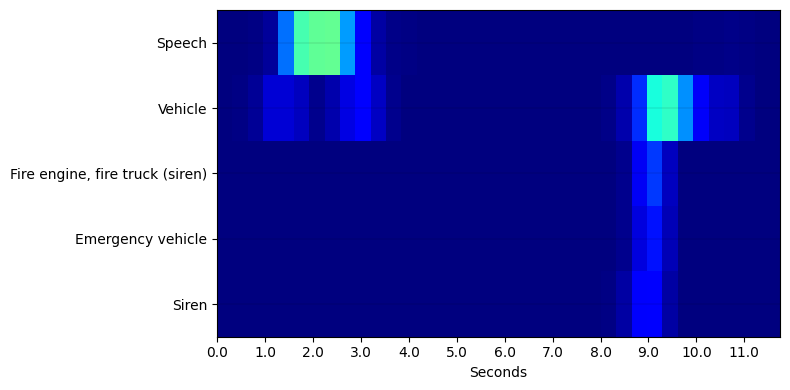

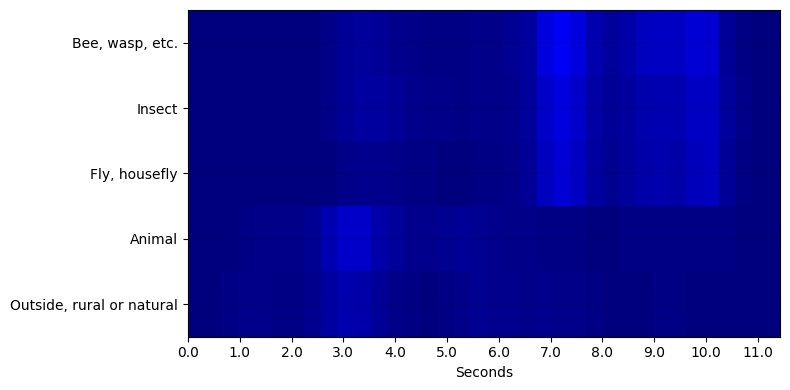

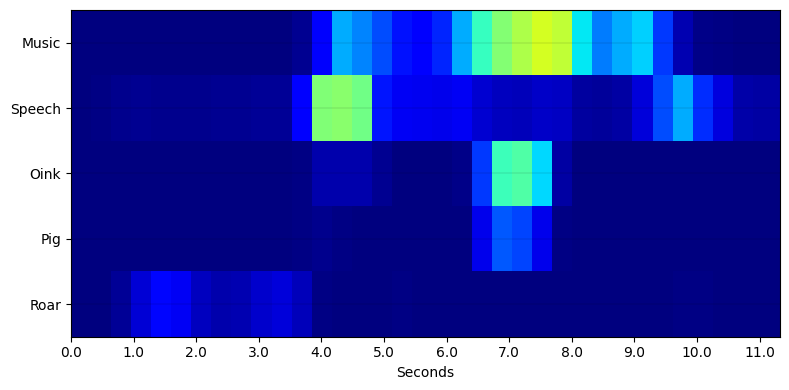

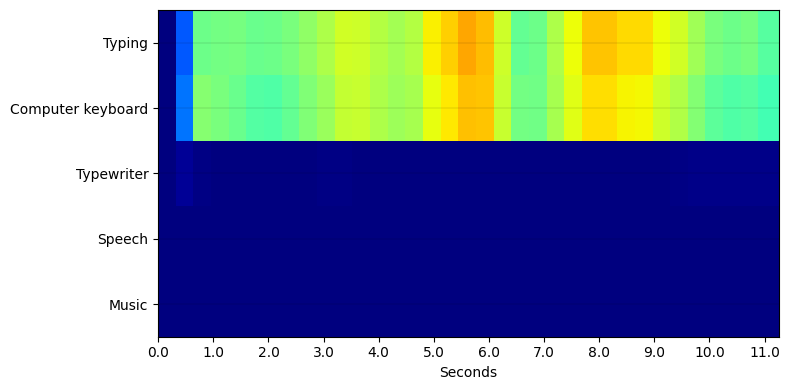

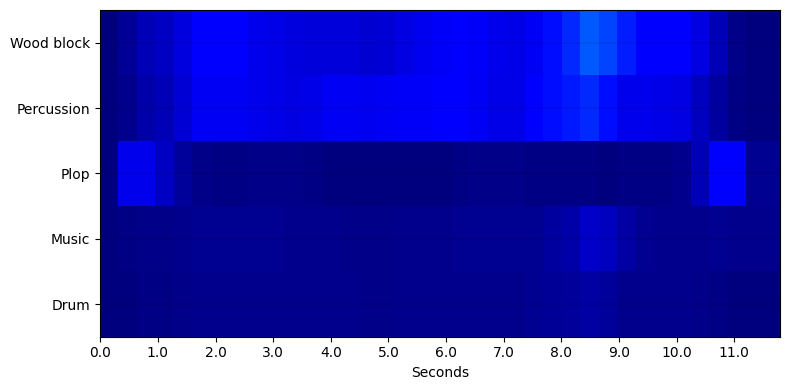

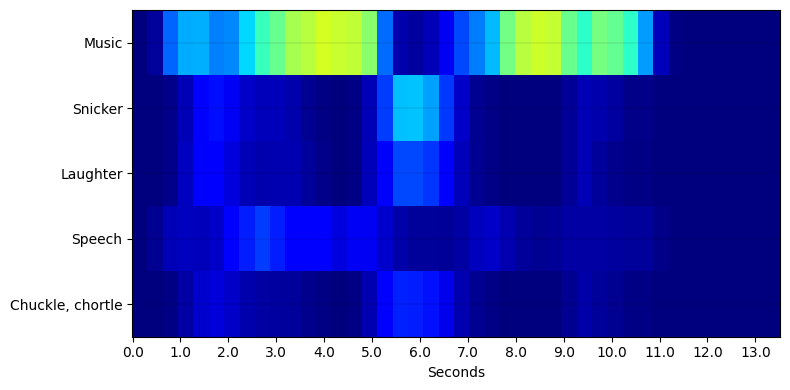

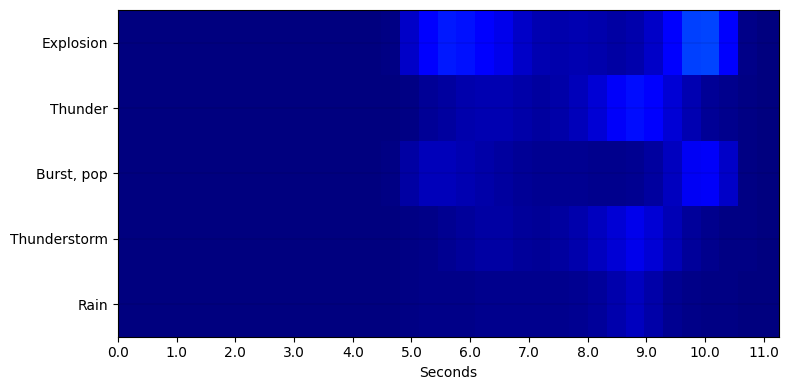

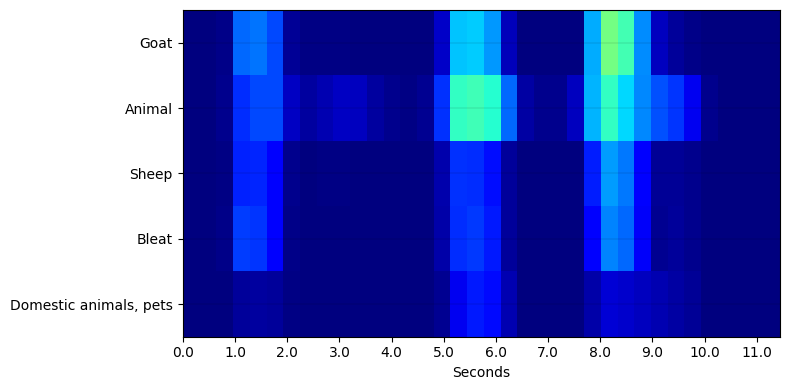

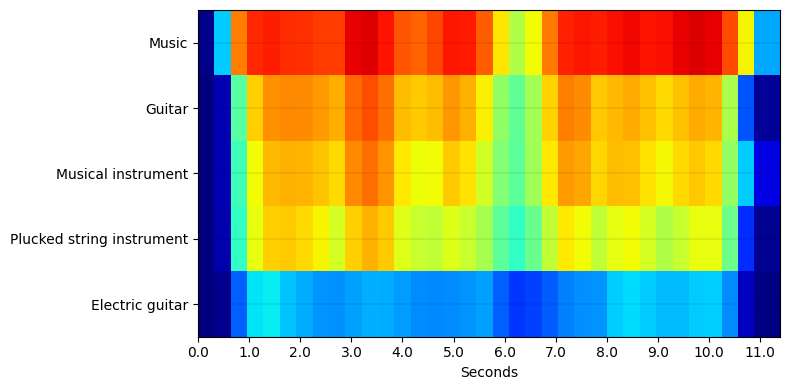

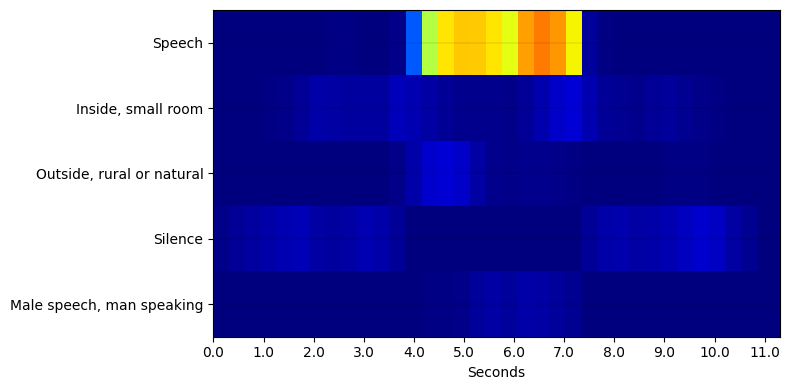

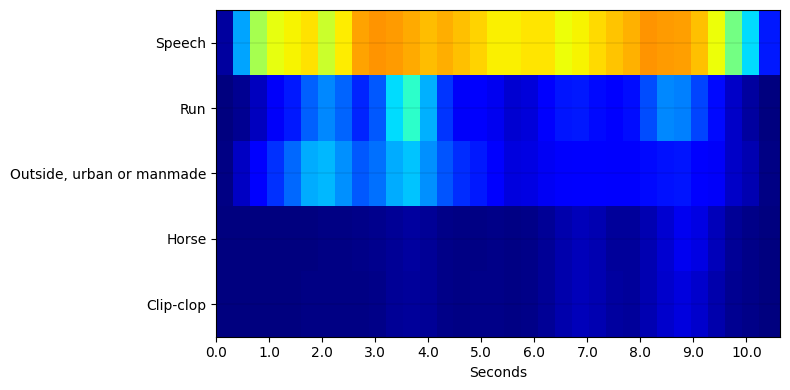

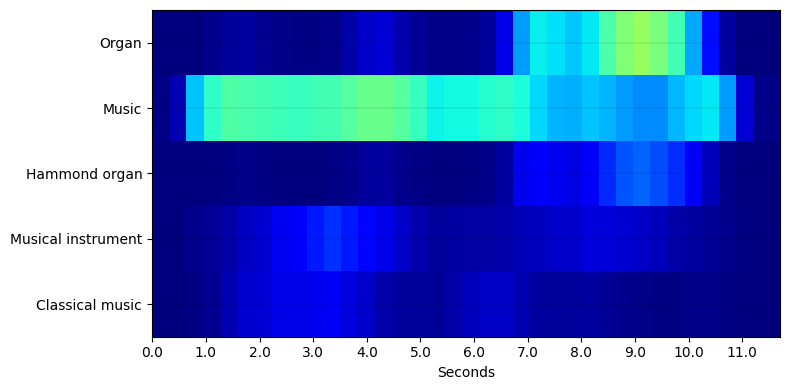

In [10]:
import pandas as pd
df = pd.read_csv("../data/dev.csv")

labels = []
for audiofile in df.loc[:,"file"]:
    _, label = my_sound_event_detection(audiofile)
    labels.append(label)
print(labels)